This notebook aims to explore the relationship between permutation symmetry and model aggregation.

_Updated on 2023/12/20_

## Import libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
from typing import Literal, List
import numpy as np
from typing import Tuple
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import wandb
# make sure wandb is running in silent mode
os.environ['WANDB_SILENT'] = "true"

In [2]:
%load_ext autoreload
%autoreload 2

## Data Preparation

For simpllicity, we use only mnist and cifar10


In [51]:
HIDDEN_SIZE = 128
model = nn.Sequential(
    nn.Linear(28 * 28, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 10),
)


def initialization_with_seed(model: nn.Module, seed: int):
    torch.manual_seed(seed)
    # initialize the weights of the model with the given seed
    for model in model.modules():
        if isinstance(model, nn.Linear):
            nn.init.kaiming_normal_(model.weight)
            nn.init.zeros_(model.bias)

In [52]:
def build_mlp_model(hidden_dimension:int=128) -> nn.Module:
    return nn.Sequential(
        nn.Linear(28 * 28, hidden_dimension),
        nn.ReLU(),
        nn.Linear(hidden_dimension, hidden_dimension),
        nn.ReLU(),
        nn.Linear(hidden_dimension, 10),
    )

In [4]:
def prepare_dataset(
    dataset_name: Literal["MNIST", "CIFAR10"], 
    model_type: Literal["MLP", "CNN"]= "MLP"
) -> Tuple[Dataset, Dataset]:
    if dataset_name == "MNIST":
        train_transforms = transforms.Compose(
            [
                transforms.ToImage(),
                transforms.RandomRotation(7),
                transforms.ToDtype(torch.float32, scale=True),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.flatten()
                                  if model_type == "MLP" 
                                  else x.view(-1, 1, 28, 28)),
            ]
        )
        test_transforms = transforms.Compose(
            [
                transforms.ToImage(),
                transforms.ToDtype(torch.float32, scale=True),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.Lambda(lambda x: x.flatten()
                                  if model_type == "MLP" 
                                  else x.view(-1, 1, 28, 28)),
            ]
        )
        trainset = datasets.MNIST(
            root="data", train=True, download=True, transform=train_transforms
        )
        testset = datasets.MNIST(
            root="data", train=False, download=True, transform=test_transforms
        )
    elif dataset_name == "CIFAR10":
        train_transforms = transforms.Compose(
            [
                transforms.ToImage(),
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToDtype(torch.float32, scale=True),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
                transforms.Lambda(lambda x: x.flatten() if model_type == "MLP" else x),
            ]
        )
        test_transforms = transforms.Compose(
            [
                transforms.ToImage(),
                transforms.ToDtype(torch.float32, scale=True),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
                transforms.Lambda(lambda x: x.flatten() if model_type == "MLP" else x),
            ]
        )
        trainset = datasets.CIFAR10(
            root="data", train=True, download=True, transform=train_transforms
        )
        testset = datasets.CIFAR10(
            root="data", train=False, download=True, transform=test_transforms
        )
    else:
        raise ValueError(f"Unknown dataset name: {dataset_name}")
    return trainset, testset

In [5]:
mnist_trainset, mnist_testset = prepare_dataset("MNIST")
print(f"MNIST trainset size: {len(mnist_trainset)}")
print(f"MNIST testset size: {len(mnist_testset)}")
cifar10_trainset, cifar10_testset = prepare_dataset("CIFAR10")
print(f"CIFAR10 trainset size: {len(cifar10_trainset)}")
print(f"CIFAR10 testset size: {len(cifar10_testset)}")

MNIST trainset size: 60000
MNIST testset size: 10000
Files already downloaded and verified
Files already downloaded and verified
CIFAR10 trainset size: 50000
CIFAR10 testset size: 10000


In [6]:
dummy_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
dummy_batch = next(iter(dummy_loader))
print(f"MNIST batch shape: {dummy_batch[0].shape}")
print(f"MNIST batch label shape: {dummy_batch[1].shape}")
dummy_test_loader = DataLoader(mnist_testset, batch_size=64, shuffle=True)
dummy_test_batch = next(iter(dummy_test_loader))
print(f"MNIST test batch shape: {dummy_test_batch[0].shape}")
print(f"MNIST test batch label shape: {dummy_test_batch[1].shape}")

MNIST batch shape: torch.Size([64, 784])
MNIST batch label shape: torch.Size([64])
MNIST test batch shape: torch.Size([64, 784])
MNIST test batch label shape: torch.Size([64])


In [7]:
dummy_loader = DataLoader(cifar10_trainset, batch_size=64, shuffle=True)
dummy_batch = next(iter(dummy_loader))
print(f"CIFAR10 batch shape: {dummy_batch[0].shape}")
print(f"CIFAR10 batch label shape: {dummy_batch[1].shape}")
dummy_test_loader = DataLoader(cifar10_testset, batch_size=64, shuffle=True)
dummy_test_batch = next(iter(dummy_test_loader))
print(f"CIFAR10 test batch shape: {dummy_test_batch[0].shape}")
print(f"CIFAR10 test batch label shape: {dummy_test_batch[1].shape}")

CIFAR10 batch shape: torch.Size([64, 3072])
CIFAR10 batch label shape: torch.Size([64])
CIFAR10 test batch shape: torch.Size([64, 3072])
CIFAR10 test batch label shape: torch.Size([64])


Dataset prepration ✅

----


Our first experiment would be aggregating models with different initialization 

Need a function To find the GPU device ID with the most available memory

In [8]:
def get_most_avaliable_device(n_gpus: int, verbose: bool = False) -> List[int]:
    gpus_profile = dict.fromkeys(range(torch.cuda.device_count()), 0)
    for gpu_id in gpus_profile.keys():
        device_properties = torch.cuda.get_device_properties(gpu_id)
        total_memory = device_properties.total_memory
        allocated_memory = torch.cuda.memory_allocated(gpu_id)
        reserved_memory = torch.cuda.memory_reserved(gpu_id)
        available_memory = total_memory - allocated_memory - reserved_memory
        gpus_profile[gpu_id] = available_memory
    sorted_gpus_profile = sorted(gpus_profile, key=lambda gpu_id: gpus_profile[gpu_id])
    selected_gpu = sorted_gpus_profile[:n_gpus]
    if verbose:
        for gpu in selected_gpu:
            memory = gpus_profile[gpu] // 1024**3
            print(f"GPU {gpu} has {memory} GB available")
    return selected_gpu


get_most_avaliable_device(2, verbose=True)

GPU 0 has 39 GB available
GPU 1 has 39 GB available


[0, 1]

Train multiple model using multiple process on Ray.

In [9]:
# multiple process training
import ray
if not ray.is_initialized():
    ray.init()

2023-12-29 16:07:08,919	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [10]:
from logger import LoggerCollection, CSVLogger
from trainer import DefaultTrainer
from torchmetrics import MetricCollection, Accuracy

In [11]:
@ray.remote(max_calls=1)
def train_with_different_initialization(seed: int, max_epochs: int = 30):
    model = nn.Sequential(
        nn.Linear(28 * 28, HIDDEN_SIZE),
        nn.ReLU(),
        nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
        nn.ReLU(),
        nn.Linear(HIDDEN_SIZE, 10),
    )
    initialization_with_seed(model, seed)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    metrics = MetricCollection(
        [
            Accuracy(task="multiclass", num_classes=10),
        ]
    )
    logger = LoggerCollection(
        [CSVLogger(
            name=f"seed_{seed}",
            saving_dir="different_initialization/logs",
        )]
    )
    trainer = DefaultTrainer(
        model=model,
        optimizer=optimizer,
        criterion=loss_fn,
        metrics=metrics,
        loggers=logger,
        device="cuda",
        saving_on="last",
        saving_dir="different_initialization/checkpoints",
        saving_name=f"seed_{seed}",
    )

    # For Dataset Reproducibility
    from pytorch_lightning import seed_everything

    seed_everything(42)
    # Load dataset
    mnist_trainset, _ = prepare_dataset("MNIST")
    mnist_train_loader = DataLoader(mnist_trainset, batch_size=256, num_workers=4)
    results = trainer.fit(
        train_loader=mnist_train_loader,
        epochs=max_epochs,
    )
    # release GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [11]:
num_tasks_in_parallel = 5
n_gpus = 2
fraction_per_gpu = float(n_gpus / num_tasks_in_parallel)
print(f"fraction per gpu: {fraction_per_gpu}")
total_tasks = num_tasks_in_parallel

fraction per gpu: 0.4


In [ ]:
# evenly distribute tasks to gpus
seeds = np.random.randint(0, 1000, size=total_tasks)
tasks_args = [(seed,) for seed in seeds]
tasks = [
    train_with_different_initialization.options(num_gpus=fraction_per_gpu).remote(*args)
    for args in tasks_args
]
try:
    results = ray.get(tasks)
except KeyboardInterrupt as e:
    # if keyboard interrupt, cancel all the tasks
    print(f"All tasks are cancelled due to {e}")
    ray.cancel(tasks, force=True)
except Exception as e:
    # if any error occurs, print the error message
    # and gracefully terminate all the tasks
    # for debugging purpose
    print(e)
    ray.cancel(tasks)
finally:
    print("All tasks are finished")
    wandb.finish()

In [ ]:
for i, result in enumerate(results):
    print(f"seed: {seeds[i]}, best accuracy: {result['train_epoch_MulticlassAccuracy']}")

In [13]:
ckpts_paths = os.listdir('different_initialization/checkpoints')
ckpts = [torch.load(os.path.join('different_initialization/checkpoints', ckpt_path)) for ckpt_path in ckpts_paths]

In [14]:
log_paths = [ckpt['csv_log_path'] for ckpt in ckpts]
log_paths

['different_initialization/logs/seed_214',
 'different_initialization/logs/seed_574',
 'different_initialization/logs/seed_63',
 'different_initialization/logs/seed_873',
 'different_initialization/logs/seed_299']

set the style of our plots

In [30]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(font='DejaVu Serif', font_scale=1)
def plot_training_curves(
    log_paths: List[str], title: str = "Training Curves"
):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for log_path in log_paths:
        logs_df = pd.read_csv(log_path)
        seed_str = log_path.split("/")[-1].split("_")[-1]
        label = f"seed:{seed_str}"
        sub_df = logs_df[['train_epoch_loss', 'train_epoch_MulticlassAccuracy']].dropna()
        sub_df['epoch'] = np.arange(len(sub_df))
        sub_df['seed' ] = seed_str
        sns.lineplot(data=sub_df, x='epoch', y='train_epoch_loss', ax=axs[0], label=label)
        sns.lineplot(data=sub_df, x='epoch', y='train_epoch_MulticlassAccuracy', ax=axs[1], label=label)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Train Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Train Accuracy")
    # share x axis
    axs[0].sharex(axs[1])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.suptitle(title)
    fig.set_tight_layout(True)
    return fig

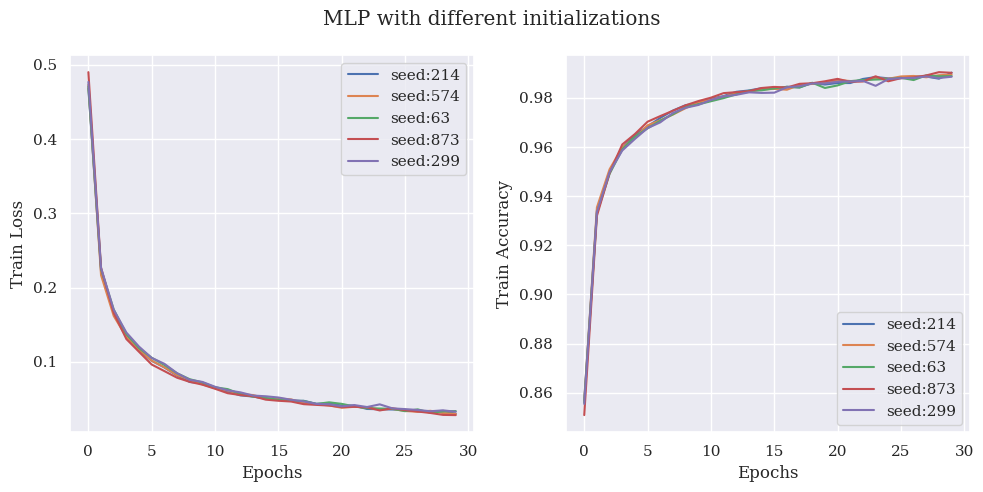

In [31]:
fig = plot_training_curves(log_paths, "MLP with different initializations")

measure the l2-difference between the parameters of them

In [22]:
def parameter_wise_difference(
    models_state_dict: List[dict], 
    type: Literal["l1", "l2", "cos"] = "l1"
):
    diffs = {}
    base_model_dict = models_state_dict[0]
    # no gradient for this
    with torch.no_grad():
        for i, model_dict in enumerate(models_state_dict[1:]):
            layer_wise_diffs = []

            # iterate through each linear layer in the base model
            for key in base_model_dict.keys():
                if 'weight' in key or 'bias' in key:
                    base_param = base_model_dict[key]
                    param = model_dict[key]
                    if type == "l1":
                        diff = torch.norm(base_param - param, p=1)
                    elif type == "l2":
                        diff = torch.norm(base_param - param, p=2)
                    elif type == "cos":
                        cos_sim = torch.nn.functional.cosine_similarity(
                            base_param.view(1, -1), param.view(1, -1), dim=1
                        )
                        diff = cos_sim.mean()
                    else:
                        raise ValueError(f"Unknown type: {type}")
                    layer_wise_diffs.append(diff.item())
            diffs[i + 1] = layer_wise_diffs
    return diffs

In [23]:
model_state_dicts = [ckpt['model_state_dict'] for ckpt in ckpts]
print(f"Total number of models: {len(model_state_dicts)}")
print(f"Total number of layers: {len(model_state_dicts[0])}")
print(f"Layer names: {model_state_dicts[0].keys()}")

Total number of models: 5
Total number of layers: 6
Layer names: odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [34]:
l2_diffs

{1: [35.424442291259766,
  0.14008840918540955,
  27.377614974975586,
  0.6736565828323364,
  10.189908027648926,
  0.10353373736143112],
 2: [35.30595397949219,
  0.13969331979751587,
  27.193470001220703,
  0.6946572065353394,
  9.804181098937988,
  0.09906256198883057],
 3: [36.15773010253906,
  0.1465759426355362,
  27.491485595703125,
  0.656825840473175,
  9.885163307189941,
  0.08503121882677078],
 4: [35.37974166870117,
  0.15704505145549774,
  27.112709045410156,
  0.7382655739784241,
  10.090188026428223,
  0.060228291898965836]}

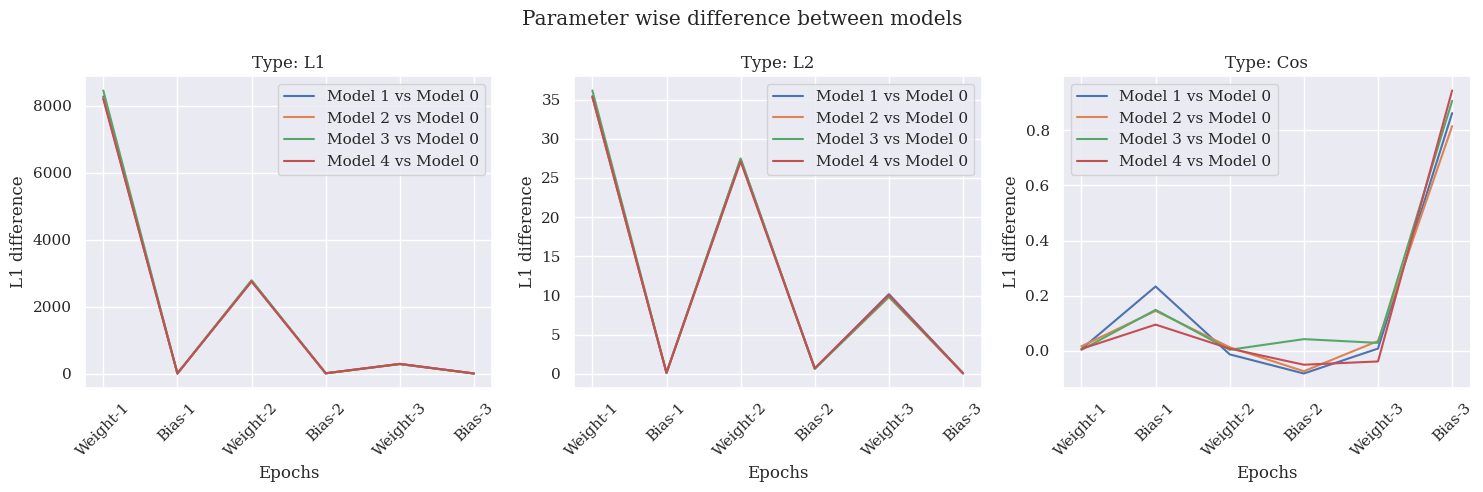

In [38]:
l2_diffs = parameter_wise_difference(model_state_dicts, type="l2")
cos_diffs = parameter_wise_difference(model_state_dicts, type="cos")
l1_diffs = parameter_wise_difference(model_state_dicts, type="l1")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# share x axis

for i, diffs in enumerate([l1_diffs, l2_diffs, cos_diffs]):
    num_layers = len(next(iter(diffs.values())))
    for layer_id, layer_diffs in diffs.items():
        sns.lineplot(data=layer_diffs, ax=axs[i], label=f"Model {layer_id} vs Model 0")
    tick_labels = [f"Weight-{int(i/2)+1}" if i % 2 == 0 else f"Bias-{int(i/2)+1}" for i in range(num_layers)]
    axs[i].set_xticks(range(num_layers))
    axs[i].set_xticklabels(tick_labels, rotation=45)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("L1 difference")
    axs[i].set_title(f"Type: {['L1', 'L2', 'Cos'][i]}")
    axs[i].legend()
fig.suptitle("Parameter wise difference between models")
fig.set_tight_layout(True)


Seems ok. Now we want to reproduce the weight averaginng experiments.

In [94]:
@ray.remote
def interpolate_weights(
    name: str,
    model1_state_dict: dict,
    model2_state_dict: dict,
    alpha: float = 0.5,
    saving_dir: str = None,
) -> dict:
    new_model_state_dict = {}
    with torch.no_grad():
        for param_name in model1_state_dict:
            assert param_name in model2_state_dict, f"Model structure mismatch: {name}"
            param1 = model1_state_dict[param_name].to("cpu")
            param2 = model2_state_dict[param_name].to("cpu")
            new_model_state_dict[param_name] = (
                alpha * param1 + (1 - alpha) * param2
            ).clone()
    results = {"name": name, "alpha": alpha, "state_dict": new_model_state_dict}
    if saving_dir is not None:
        if not os.path.exists(saving_dir):
            os.makedirs(saving_dir)
        torch.save(results, os.path.join(saving_dir, f"{name}-alpha:{alpha:.2f}.pth"))
    return results

In [95]:
def interpolation_experiments(
    state_dicts_list: List[dict],
) -> dict:
    alphas = np.linspace(0, 1, num=11)
    base_state_dict = state_dicts_list[0]
    tasks = []
    for alpha in alphas:
        for i, state_dict in enumerate(state_dicts_list[1:]):
            saving_dir = "different_initialization/interpolated_state_dicts"
            task = interpolate_weights.remote(
                f"model0-model{i+1}",
                base_state_dict,
                state_dict,
                alpha,
                saving_dir,
            )
            tasks.append(task)
    results = ray.get(tasks)
    # prepare the results into the format of
    # name: {alpha: [0, 0.1, 0.2, ...], state_dict: [corresponding state dict]}
    results_dict = {}
    for result in results:
        name = result["name"]
        alpha = result["alpha"]
        state_dict = result["state_dict"]
        if name not in results_dict:
            results_dict[name] = {"alpha": [], "state_dict": []}
        results_dict[name]["alpha"].append(alpha)
        results_dict[name]["state_dict"].append(state_dict)
    return results_dict

In [96]:
# make sure all on cpu
model_state_dicts[0]
results_dict = interpolation_experiments(model_state_dicts)

evaluate the interpolatated models. But before that, write a function called build model.

In [98]:
@ray.remote
def evaluate_interpolated_model(
    name: str,
    model_state_dict: dict,
    device: Literal["cpu", "cuda"]="cuda",
):
    model = build_mlp_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    metrics = MetricCollection(
        [
            Accuracy(task="multiclass", num_classes=10),
        ]
    )
    from logger import DummyPrintLogger, LoggerCollection
    loggers = LoggerCollection([DummyPrintLogger()])
    try:
        model.load_state_dict(model_state_dict)
    except Exception as e:
        print(f"Error when loading state dict: {e}")
        return None
    from pytorch_lightning import seed_everything
    seed_everything(42)
    _, mnist_testset = prepare_dataset("MNIST")
    mnist_test_loader = DataLoader(mnist_testset, batch_size=1024, num_workers=4)
    trainer = DefaultTrainer(
        model=model,
        optimizer = optimizer,
        criterion=criterion,
        metrics=metrics,
        loggers=loggers,
        device=device,
        saving_dir="different_initialization/interpolated_state_dicts",
        saving_name=name,
    )
    results = trainer.evaluate(mnist_test_loader)  
    test_loss = results["test_epoch_loss"]
    test_acc = results["test_epoch_MulticlassAccuracy"]
    results = {"name": name, "test_loss": test_loss, "test_acc": test_acc}
    # trainer.save()
    # release GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [99]:
results_dict.keys()

dict_keys(['model0-model1', 'model0-model2', 'model0-model3', 'model0-model4'])

In [100]:
tasks = []
for name, data in results_dict.items():
    alphas = data["alpha"]
    state_dicts = data["state_dict"]
    for alpha, state_dict in zip(alphas, state_dicts):
        task_name = f"{name}-alpha:{alpha:.2f}"
        task = evaluate_interpolated_model.options(num_gpus=0.1).remote(
            task_name, state_dict, "cuda"
        )
        tasks.append(task)
try:
    evaluated_results = ray.get(tasks)
except KeyboardInterrupt as e:
    # if keyboard interrupt, cancel all the tasks
    print(f"All tasks are cancelled due to {e}")
    ray.cancel(tasks, force=True)
except Exception as e:
    # if any error occurs, print the error message
    # and gracefully terminate all the tasks
    # for debugging purpose
    print(e)
    ray.cancel(tasks)
finally:
    print("All tasks are finished")

(evaluate_interpolated_model pid=3060892) Global seed set to 42


(evaluate_interpolated_model pid=3060892) Evaluation Starts


100%|██████████| 10/10 [00:01<00:00,  6.38it/s] 
(evaluate_interpolated_model pid=3061113) Global seed set to 42 [repeated 39x across cluster]


(evaluate_interpolated_model pid=3060892) Evaluation Ends
(evaluate_interpolated_model pid=3060892) Test Results: {'test_epoch_MulticlassAccuracy': 0.5699999928474426, 'test_epoch_loss': 1.1164916813373567}


100%|██████████| 10/10 [00:02<00:00,  4.71it/s] [repeated 2x across cluster]
(evaluate_interpolated_model pid=3065159) Global seed set to 42 [repeated 2x across cluster]


(evaluate_interpolated_model pid=3060889) Evaluation Starts [repeated 2x across cluster]
(evaluate_interpolated_model pid=3060903) Evaluation Ends
(evaluate_interpolated_model pid=3060903) Test Results: {'test_epoch_MulticlassAccuracy': 0.621399998664856, 'test_epoch_loss': 1.065189927816391}


100%|██████████| 10/10 [00:05<00:00,  1.89it/s] 


(evaluate_interpolated_model pid=3060889) Evaluation Ends
(evaluate_interpolated_model pid=3060889) Test Results: {'test_epoch_MulticlassAccuracy': 0.8485999703407288, 'test_epoch_loss': 0.493827810883522}
(evaluate_interpolated_model pid=3061034) Evaluation Starts
(evaluate_interpolated_model pid=3060950) Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s]3060950) 
(evaluate_interpolated_model pid=3065829) Global seed set to 42
100%|██████████| 10/10 [00:06<00:00,  1.53it/s] 


(evaluate_interpolated_model pid=3060950) Evaluation Ends [repeated 2x across cluster]
(evaluate_interpolated_model pid=3060950) Test Results: {'test_epoch_MulticlassAccuracy': 0.9713000059127808, 'test_epoch_loss': 0.10158661156892776} [repeated 2x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 6x across cluster]


(evaluate_interpolated_model pid=3061159) Evaluation Starts [repeated 6x across cluster]


 10%|█         | 1/10 [00:02<00:25,  2.85s/it] [repeated 9x across cluster]


(evaluate_interpolated_model pid=3060891) Evaluation Ends [repeated 9x across cluster]
(evaluate_interpolated_model pid=3060891) Test Results: {'test_epoch_MulticlassAccuracy': 0.4661000072956085, 'test_epoch_loss': 1.4648432374000548} [repeated 9x across cluster]


100%|██████████| 10/10 [00:03<00:00,  3.19it/s] [repeated 13x across cluster]
(evaluate_interpolated_model pid=3067782) Global seed set to 42
  0%|          | 0/10 [00:00<?, ?it/s] [repeated 26x across cluster]


(evaluate_interpolated_model pid=3061065) Evaluation Starts [repeated 27x across cluster]


100%|██████████| 10/10 [00:01<00:00,  5.51it/s] [repeated 42x across cluster]


(evaluate_interpolated_model pid=3061113) Evaluation Ends [repeated 26x across cluster]
(evaluate_interpolated_model pid=3061113) Test Results: {'test_epoch_MulticlassAccuracy': 0.5192999839782715, 'test_epoch_loss': 1.3399833202362061} [repeated 26x across cluster]


 60%|██████    | 6/10 [00:00<00:00,  8.30it/s] 


(evaluate_interpolated_model pid=3067782) Evaluation Starts [repeated 6x across cluster]
All tasks are finished


(evaluate_interpolated_model pid=3067782) Evaluation Ends
(evaluate_interpolated_model pid=3067782) Test Results: {'test_epoch_MulticlassAccuracy': 0.9753999710083008, 'test_epoch_loss': 0.10382360238581896}


100%|██████████| 10/10 [00:01<00:00,  8.01it/s] 


In [101]:
def evaluated_results_to_df(evaluated_results: List[dict]):
    df = pd.DataFrame(evaluated_results)
    get_alpha = lambda x: float(x.split(":")[-1])
    get_comparing_models = lambda x: str.join("-", x.split("-")[:-1])
    df["alpha"] = df["name"].apply(get_alpha)
    df["models for comparison"] = df["name"].apply(get_comparing_models)
    df = df.sort_values(by=["models for comparison", "alpha"])
    return df

In [ ]:

df = evaluated_results_to_df(evaluated_results)
df.head()

In [319]:
import pickle
with open("pkl/interpolated_models_accuracy.pkl", "wb") as f:
    pickle.dump(df, f)

In [42]:
# if rerunning, pleas load the saved pickle file
import pickle
df = pickle.load(open("pkl/interpolated_models_accuracy.pkl", "rb"))

In [43]:
from matplotlib.pyplot import Axes
def remove_duplicated_labels(gca: Axes):
    handles, labels = gca.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    return by_label.values(), by_label.keys()

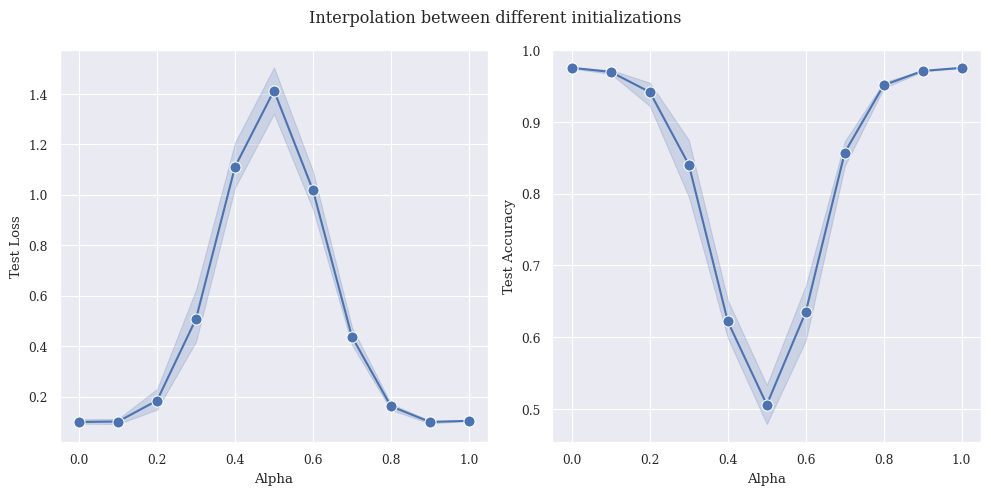

In [44]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(font="DejaVu Serif")
sns.set_context("paper")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(
    data=df,
    x="alpha",
    y="test_loss",
    ax=axs[0],
    linewidth=1.5,
    marker='o',
    markersize=8,
)
legend, labels = axs[0].get_legend_handles_labels()
sns.lineplot(
    data=df,
    x="alpha",
    y="test_acc",
    ax=axs[1],
    legend=False,
    linewidth=1.5,
    marker='o',
    markersize=8,
)
axs[0].set_xlabel("Alpha")
axs[0].set_ylabel("Test Loss")
axs[1].set_xlabel("Alpha")
axs[1].set_ylabel("Test Accuracy")
# handles, labels = remove_duplicated_labels(axs[0])
fig.suptitle("Interpolation between different initializations")
fig.set_tight_layout(True)

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Union, Tuple, Literal
from torch import Callable

def get_all_activations(
    model_builder: Callable[[], nn.Module],
    state_dict: dict,
    val_loader: DataLoader,
    device: Literal["cpu", "cuda"],
    activation_types: Union[type, Tuple[type, ...]],
) -> dict:
    model = model_builder()
    try:
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error when loading state dict: {e}")
        return None
    activations_by_layers = {}
    # Nested hook function
    def get_layer_activations(
        module: nn.Module, input: torch.Tensor, output: torch.Tensor
    ):
        layer_id = id(module)
        layer_name = f"{module.__class__.__name__}_{layer_id}"
        if layer_name not in activations_by_layers:
            activations_by_layers[layer_name] = []
        activations_by_layers[layer_name].append(output.cpu().detach())
    # Register hook
    hooks = []
    for depth, module in enumerate(model.modules()):
        if isinstance(module, activation_types):
            hook = module.register_forward_hook(get_layer_activations)
            hooks.append(hook)
    # Forward pass
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            model(inputs)
    # Remove hooks
    for hook in hooks:
        hook.remove()
    # make sure the model is returning to the original device
    model.to("cpu")
    # Process activations
    final_activations = {}
    for depth, (layer_name, activations) in enumerate(activations_by_layers.items()):
        readable_layer_name = layer_name.split("_")[0] + f"_{depth}"
        final_activations[readable_layer_name] = torch.cat(activations, dim=0)
    return final_activations

In [54]:
def compute_matching_cost(
    z1: np.ndarray or torch.Tensor, z2: np.ndarray or torch.Tensor
) -> torch.Tensor:
    if isinstance(z1, np.ndarray):
        z1 = torch.from_numpy(z1)
    if isinstance(z2, np.ndarray):
        z2 = torch.from_numpy(z2)
    z1 = z1.clone().detach().requires_grad_(False)
    z2 = z2.clone().detach().requires_grad_(False)
    z1_expanded = z1.unsqueeze(2)
    z2_expanded = z2.unsqueeze(1)
    cost_matrix = torch.norm(z1_expanded - z2_expanded, dim=0)
    return cost_matrix

In [55]:
def clear_all_hooks(model: nn.Module):
    for module in model.modules():
        if hasattr(module, "_forward_hooks"):
            module._forward_hooks.clear()
        if hasattr(module, "_backward_hooks"):
            module._backward_hooks.clear()

In [56]:
ckpt_paths = os.listdir("different_initialization/checkpoints")
ckpt_1 = torch.load(os.path.join("different_initialization/checkpoints", 
                                 ckpt_paths[0]))
state_dict_1 = ckpt_1["model_state_dict"]
    

In [57]:
val_size = 100
val_loader = DataLoader(
    torch.utils.data.Subset(mnist_testset, range(val_size)),
    batch_size=1000,
    shuffle=False,
    num_workers=4,
)
activations = get_all_activations(
    build_mlp_model,
    state_dict_1, val_loader, "cuda", activation_types=(nn.ReLU, nn.Softmax)
)

In [58]:
for name, activation in activations.items():
    print(f"{name}: {activation.shape}")

ReLU_0: torch.Size([100, 128])
ReLU_1: torch.Size([100, 128])


Our implementation seems to be correct so far. Let's get the cost matrix of model 0 and model 1

In [59]:
ckpt_2 = torch.load(os.path.join("different_initialization/checkpoints",
                                    ckpt_paths[1]))
state_dict_2 = ckpt_2["model_state_dict"]
activations_2 = get_all_activations(
    build_mlp_model,
    state_dict_2, val_loader, "cuda", activation_types=(nn.ReLU, nn.Softmax)
)

In [60]:
def compute_cost_matrices(
    activations_1: dict or List[torch.Tensor], activations_2: dict or List[torch.Tensor]
) -> List[np.ndarray]:
    cost_matrices = []
    if isinstance(activations_1, dict):
        activations_1 = list(activations_1.values())
    if isinstance(activations_2, dict):
        activations_2 = list(activations_2.values())
    for activation_1, activation_2 in zip(activations_1, activations_2):
        cost_matrix = compute_matching_cost(activation_1, activation_2)
        cost_matrix = cost_matrix.cpu().numpy()
        cost_matrices.append(cost_matrix)
    return cost_matrices

In [61]:
cost_matrices = compute_cost_matrices(activations, activations_2)
for cost_matrix in cost_matrices:
    print(cost_matrix.shape)

(128, 128)
(128, 128)


Solve the assignment problem

In [62]:
from scipy.optimize import linear_sum_assignment
def permutation_mapping(cost_matrix: np.ndarray) -> (np.ndarray, np.ndarray):
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    return row_indices, col_indices

Let's say whether it works or not

In [63]:
for i, cost_matrix in enumerate(cost_matrices):
    row_indices, col_indices = permutation_mapping(cost_matrix)
    print(f"For the {i}th layer")
    cost_before = np.diagonal(cost_matrix).sum()
    cost_after = cost_matrix[row_indices, col_indices].sum()
    print(f"Cost before: {cost_before}")
    print(f"Cost after: {cost_after}")

For the 0th layer
Cost before: 4105.91796875
Cost after: 2132.64990234375
For the 1th layer
Cost before: 5258.05517578125
Cost after: 3139.17822265625


Works! Let's write a function to permute the weight and bias according to the row_indices, and col_indices

In [64]:
from copy import deepcopy
def permute_model(
    model:nn.Module, permutations: List[np.array]
) -> nn.Module:
    # get all lineary layers in the model
    linear_layers = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            linear_layers.append(module)
    assert (
        len(linear_layers) == len(permutations) + 1
    ), "Mismatch between the number of linear layers and the permutation"
    for i in range(len(linear_layers) - 1):
        permutation = permutations[i]
        linear_layers[i].weight.data = linear_layers[i].weight.data[permutation]
        if linear_layers[i].bias is not None:
            linear_layers[i].bias.data = linear_layers[i].bias.data[permutation]
        next_layer = linear_layers[i + 1]
        next_layer.weight.data = next_layer.weight.data[:, permutation]
    new_state_dict = deepcopy(model.state_dict())
    return new_state_dict

In [65]:
permuations = [
    col_indices
    for _, col_indices in [
        permutation_mapping(cost_matrix) for cost_matrix in cost_matrices
    ]
]

In [66]:
model = build_mlp_model()
model.load_state_dict(state_dict_2)
new_state_dict = permute_model(model, permuations)

In [67]:
for key in state_dict_2.keys():
    if not torch.equal(new_state_dict[key], state_dict_2[key]):
        print(f"Layer {key} is not equal")
    else:
        print(f"Layer {key} is equal")

Layer 0.weight is not equal
Layer 0.bias is not equal
Layer 2.weight is not equal
Layer 2.bias is not equal
Layer 4.weight is not equal
Layer 4.bias is equal


Let's test the permuted_model has the same peformance.

In [70]:
from logger import DummyPrintLogger, LoggerCollection
test_loader = DataLoader(mnist_testset, batch_size=1024, num_workers=4)
def quick_evaluate(model, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    metrics = MetricCollection(
        [
            Accuracy(task="multiclass", num_classes=10),
        ]
    )
    loggers = LoggerCollection([DummyPrintLogger()])
    trainer = DefaultTrainer(
        model=model,
        optimizer = optimizer,
        criterion=criterion,
        metrics=metrics,
        loggers=loggers,
        device="cuda",
        need_saving=False,
    )
    results = trainer.evaluate(test_loader)  
    test_loss = results["test_epoch_loss"]
    test_acc = results["test_epoch_MulticlassAccuracy"]
    return test_loss, test_acc

In [71]:
print("Original Model")
model.load_state_dict(state_dict_2)
test_loss, test_acc = quick_evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f} \nTest Accuracy: {test_acc:.4f}')

Original Model
Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.72it/s]

Evaluation Ends
Test Results: {'test_epoch_MulticlassAccuracy': 0.9739000201225281, 'test_epoch_loss': 0.11565011795610189}
Test Loss: 0.1157 
Test Accuracy: 0.9739


In [72]:
print("Permuted Model")
model.load_state_dict(new_state_dict) 
test_loss, test_acc = quick_evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f} \nTest Accuracy: {test_acc:.4f}')

Permuted Model
Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.56it/s]

Evaluation Ends
Test Results: {'test_epoch_MulticlassAccuracy': 0.9739000201225281, 'test_epoch_loss': 0.11565012335777283}
Test Loss: 0.1157 
Test Accuracy: 0.9739


In [73]:
print("Interpolation without permutation")
alpha = 0.5
interpolated_state_dict_no_permutation = {}
for key in state_dict_1.keys():
    interpolated_state_dict_no_permutation[key] = (
        alpha * state_dict_1[key] + (1 - alpha) * state_dict_2[key]
    ).clone()
model.load_state_dict(interpolated_state_dict_no_permutation)
test_loss, test_acc = quick_evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f} \nTest Accuracy: {test_acc:.4f}')


Interpolation without permutation
Evaluation Starts


100%|██████████| 10/10 [00:01<00:00,  9.88it/s]

Evaluation Ends
Test Results: {'test_epoch_MulticlassAccuracy': 0.4661000072956085, 'test_epoch_loss': 1.4648432374000548}
Test Loss: 1.4648 
Test Accuracy: 0.4661


In [74]:
print("Interpolation with permutation")
interpolated_state_dict_with_permutation = {}
for key in state_dict_1.keys():
    interpolated_state_dict_with_permutation [key] = (
        (1 - alpha) * state_dict_1[key] + alpha * new_state_dict[key]
    ).clone()
model.load_state_dict(interpolated_state_dict_with_permutation )
test_loss, test_acc = quick_evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f} \nTest Accuracy: {test_acc:.4f}')

Interpolation with permutation
Evaluation Starts


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

Evaluation Ends
Test Results: {'test_epoch_MulticlassAccuracy': 0.9157999753952026, 'test_epoch_loss': 0.2692721769213676}
Test Loss: 0.2693 
Test Accuracy: 0.9158


The permuted model has almost the same accuracy as before, indicating that permuting models are essentially the same as the unpermuted one.
Meanwhile, after permutation, the interpolating two model seems to produce better results. 

Does permutation really helps?, we should verify it for all our models.

In [75]:
from typing import Callable
def match_and_permute(
    state_dict_1:dict,
    state_dict_2: dict, 
    model_builder: Callable[[], nn.Module],
    val_loader: DataLoader,
    device: Literal["cpu", "cuda"]="cuda",
    activation_types: Union[type, Tuple[type, ...]]= (nn.ReLU, nn.Softmax)):
    activations_1 = get_all_activations(
        model_builder,
        state_dict_1, val_loader, device, activation_types
    )
    activations_2 = get_all_activations(
        model_builder,
        state_dict_2, val_loader, device, activation_types
    )
    cost_matrices = compute_cost_matrices(activations_1, activations_2)
    permutations = []
    for i, cost_matrix in enumerate(cost_matrices):
        row_indices, col_indices = permutation_mapping(cost_matrix)
        # print(f"For the {i}th layer")
        cost_before = np.diagonal(cost_matrix).sum()
        cost_after = cost_matrix[row_indices, col_indices].sum()
        # print(f"Cost before: {cost_before}")
        # print(f"Cost after: {cost_after}")
        permutations.append(col_indices)
    model = model_builder()
    model.load_state_dict(state_dict_2)
    new_state_dict = permute_model(model, permutations)
    return new_state_dict

In [76]:
results_without_permutation = pickle.load(
    open('pkl/interpolated_models_accuracy.pkl', 'rb')
)
results_without_permutation.head()

,name,test_loss,test_acc,alpha,models for comparison
0,model0-model1-alpha:0.00,0.115650,0.9739,0.0,model0-model1
1,model0-model1-alpha:0.10,0.114753,0.9679,0.1,model0-model1
2,model0-model1-alpha:0.20,0.186122,0.9455,0.2,model0-model1
3,model0-model1-alpha:0.30,0.493828,0.8486,0.3,model0-model1
4,model0-model1-alpha:0.40,1.128648,0.5975,0.4,model0-model1


In [77]:
def permute_and_interpolate(
    state_dict_1: dict,
    state_dict_2: dict,
    model_builder: Callable[[], nn.Module],
    val_loader: DataLoader, 
    alpha:float,
    name: str,
    saving_dir: str
):
    permuted_state_dict = match_and_permute(
        state_dict_1, 
        state_dict_2,
        model_builder,
        val_loader,
    )
    new_model_state_dict = {}
    with torch.no_grad():
        for param_name in state_dict_1:
            assert param_name in permuted_state_dict, f"Model structure mismatch: {name}"
            param1 = state_dict_1[param_name].to("cpu")
            param2 = permuted_state_dict[param_name].to("cpu")
            new_model_state_dict[param_name] = (
                alpha * param1 + (1 - alpha) * param2
            ).clone()
    results = {"name": name, "alpha": alpha, "state_dict": new_model_state_dict}
    if saving_dir is not None:
        if not os.path.exists(saving_dir):
            os.makedirs(saving_dir)
        torch.save(results, os.path.join(saving_dir, f"{name}-alpha:{alpha:.2f}.pth"))
    return results
    

In [168]:
permuted_results_dict = {}
alphas = np.linspace(0, 1, num=11)
base_state_dict = model_state_dicts[0]
tasks_pool = []
model_builder = build_mlp_model
rmt_permute_and_interpolate = ray.remote(permute_and_interpolate)
saving_dir = "different_initialization/permuted_interpolated_state_dicts"
for alpha in alphas:
    for i, state_dict in enumerate(model_state_dicts[1:]):
        tasks_pool.append(
                rmt_permute_and_interpolate.remote(
                    base_state_dict,
                    state_dict,
                    model_builder,
                    val_loader,
                    alpha,
                    f"permuted-model0-model{i+1}",
                    saving_dir,
                )
            )
results = ray.get(tasks_pool)
for result in results:
    name = result["name"]
    alpha = result["alpha"]
    state_dict = result["state_dict"]
    if name not in permuted_results_dict:
        permuted_results_dict[name] = {"alpha": [], "state_dict": []}
    permuted_results_dict[name]["alpha"].append(alpha)
    permuted_results_dict[name]["state_dict"].append(state_dict)

This seems takes to long. Let's profile it and find what's the bottle neck.

In [169]:
tasks = []
for name, data in permuted_results_dict.items():
    alphas = data["alpha"]
    state_dicts = data["state_dict"]
    for alpha, state_dict in zip(alphas, state_dicts):
        task_name = f"{name}-alpha:{alpha:.2f}"
        task = evaluate_interpolated_model.options(num_gpus=0.1).remote(
            task_name, state_dict, "cuda"
        )
        tasks.append(task)
try:
    permuted_evaluated_results = ray.get(tasks)
except KeyboardInterrupt as e:
    # if keyboard interrupt, cancel all the tasks
    print(f"All tasks are cancelled due to {e}")
    ray.cancel(tasks, force=True)
except Exception as e:
    # if any error occurs, print the error message
    # and gracefully terminate all the tasks
    # for debugging purpose
    print(e)
    ray.cancel(tasks)
finally:
    print("All tasks are finished")

(evaluate_interpolated_model pid=3455924) Global seed set to 42


(evaluate_interpolated_model pid=3455933) Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s]3455933) 
(evaluate_interpolated_model pid=3455929) Global seed set to 42 [repeated 39x across cluster]
100%|██████████| 10/10 [00:05<00:00,  2.45it/s] 


(evaluate_interpolated_model pid=3455925) Evaluation Starts [repeated 6x across cluster]
(evaluate_interpolated_model pid=3455933) Evaluation Ends
(evaluate_interpolated_model pid=3455933) Test Results: {'test_epoch_MulticlassAccuracy': 0.9758999943733215, 'test_epoch_loss': 0.09588598385453224}


100%|██████████| 10/10 [00:04<00:00,  2.16it/s] [repeated 6x across cluster]


(evaluate_interpolated_model pid=3455927) Evaluation Starts [repeated 21x across cluster]
(evaluate_interpolated_model pid=3455921) Evaluation Ends [repeated 5x across cluster]
(evaluate_interpolated_model pid=3455921) Test Results: {'test_epoch_MulticlassAccuracy': 0.9696000218391418, 'test_epoch_loss': 0.11933142542839051} [repeated 5x across cluster]


(evaluate_interpolated_model pid=3463248) Global seed set to 42
100%|██████████| 10/10 [00:01<00:00,  6.65it/s] [repeated 50x across cluster]


(evaluate_interpolated_model pid=3463248) Evaluation Starts [repeated 13x across cluster]
(evaluate_interpolated_model pid=3463248) Evaluation Ends [repeated 35x across cluster]
(evaluate_interpolated_model pid=3463248) Test Results: {'test_epoch_MulticlassAccuracy': 0.9527000188827515, 'test_epoch_loss': 0.16705043911933898} [repeated 35x across cluster]


(evaluate_interpolated_model pid=3467175) Global seed set to 42 [repeated 3x across cluster]


All tasks are finished


(evaluate_interpolated_model pid=3467175) Evaluation Ends
(evaluate_interpolated_model pid=3467175) Test Results: {'test_epoch_MulticlassAccuracy': 0.9753999710083008, 'test_epoch_loss': 0.10382360238581896}


100%|██████████| 10/10 [00:01<00:00,  9.09it/s] 


In [315]:
permuted_df = evaluated_results_to_df(permuted_evaluated_results)
pickle.dump(permuted_df, open('pkl/permuted_interpolated_models_accuracy.pkl', 'wb'))

In [79]:
# if rerunning, pleas load the saved pickle file
permuted_df = pickle.load(open('pkl/permuted_interpolated_models_accuracy.pkl', 'rb'))

In [80]:
permuted_df.head()


,name,test_loss,test_acc,alpha,models for comparison
0,permuted-model0-model1-alpha:0.00,0.115650,0.9739,0.0,permuted-model0-model1
1,permuted-model0-model1-alpha:0.10,0.119331,0.9696,0.1,permuted-model0-model1
2,permuted-model0-model1-alpha:0.20,0.150448,0.9601,0.2,permuted-model0-model1
3,permuted-model0-model1-alpha:0.30,0.204059,0.9414,0.3,permuted-model0-model1
4,permuted-model0-model1-alpha:0.40,0.259255,0.9202,0.4,permuted-model0-model1


In [81]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(font='DejaVu Serif')

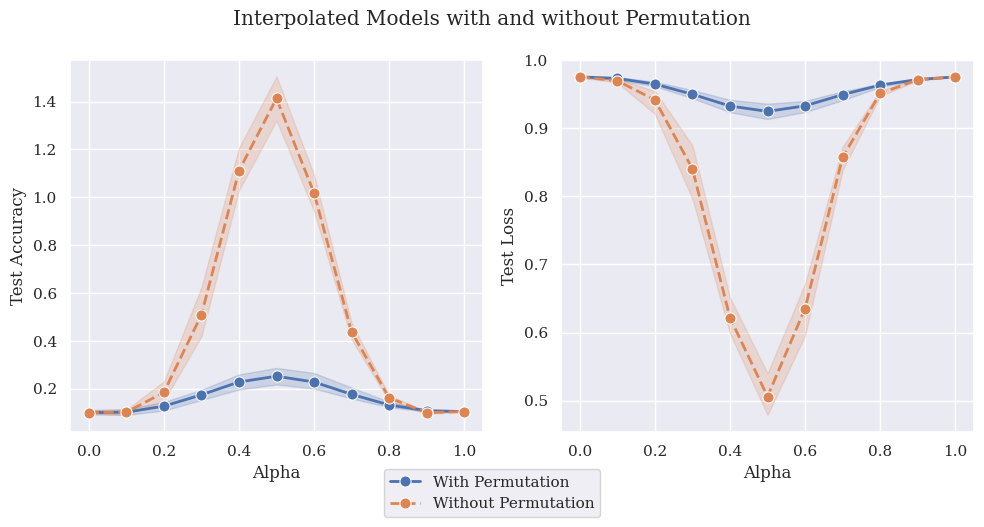

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=permuted_df, x="alpha", 
             y="test_acc", 
               ax=axs[1],
               linewidth=2,
               marker='o', markersize=8,
               label="With Permutation", 
               legend=False)
sns.lineplot(data=df, x="alpha", 
             y="test_acc", 
               ax=axs[1],
               linewidth=2, 
               marker='o', markersize=8, 
               linestyle='--', 
               label="Without Permutation", 
               legend=False)
labels, handles = axs[1].get_legend_handles_labels()
sns.lineplot(data=permuted_df, x="alpha",
             y="test_loss",
              ax=axs[0],
              linewidth=2,
              marker='o', markersize=8,
              label="With Permutation",
              legend=False)
sns.lineplot(data=df, x="alpha",
             ax=axs[0],
              y="test_loss",
              linewidth=2,
              marker='o', markersize=8,
              linestyle='--',
              label="Without Permutation",
              legend=False)
axs[0].set_xlabel("Alpha")
axs[0].set_ylabel("Test Accuracy")
axs[1].set_xlabel("Alpha")
axs[1].set_ylabel("Test Loss")
legend, labels = axs[1].get_legend_handles_labels()
legend, labels = remove_duplicated_labels(axs[1])
fig.suptitle("Interpolated Models with and without Permutation")
fig.legend(legend, labels, loc="lower center", bbox_to_anchor=(0.5, -.05), )
fig.tight_layout()
plt.show()


so far, we do observe that matching and permuting weights among different models improve the interpolated model's performance. 


---

Some papers say that this pheonomenon is due to the dropout stability of the neural networks.

To me, it makes sense as when a model is trained with high dropout proabability, it is expected to works when some neurons are being shutdown. Thus, when aggregating two models, even if the other model contains only random noise, the dropout stable networks should still have decent performance

But, it's worth verifying.

In [83]:
def build_dropout_mlp_model(dropout_rate: float=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Linear(28 * 28, HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(HIDDEN_SIZE, 10),
    )

In [84]:
def train_with_different_dropout_rate(dropout_rate:float=0.5) -> dict:
    model = build_dropout_mlp_model(dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    metrics = MetricCollection(
        [
            Accuracy(task="multiclass", num_classes=10),
        ]
    )
    logger = LoggerCollection(
        [CSVLogger(
            name=f"dropout_rate_{dropout_rate}",
            saving_dir="different_dropout/logs",
        )]
    )
    trainer = DefaultTrainer(
        model=model,
        optimizer=optimizer,
        criterion=loss_fn,
        metrics=metrics,
        loggers=logger,
        device="cuda",
        saving_on="last",
        saving_dir="different_dropout/checkpoints",
        saving_name=f"dropout_rate_{dropout_rate}",
    )

    # For Dataset Reproducibility
    from pytorch_lightning import seed_everything

    seed_everything(42)
    # Load dataset
    mnist_trainset, _ = prepare_dataset("MNIST")
    mnist_train_loader = DataLoader(mnist_trainset, batch_size=256, num_workers=4)
    results = trainer.fit(
        train_loader=mnist_train_loader,
        epochs=30,
    )
    # release GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [245]:
rmt_train_with_different_dropout_rate = ray.remote(num_gpus=0.2)(train_with_different_dropout_rate)
tasks_pool = []
for dropout_rate in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    tasks_pool.append(
        rmt_train_with_different_dropout_rate.remote(dropout_rate)
    )
try:
    summary_results = ray.get(tasks_pool)
except KeyboardInterrupt as e:
    # if keyboard interrupt, cancel all the tasks
    print(f"All tasks are cancelled due to {e}")
    ray.cancel(tasks_pool, force=True)
except Exception as e:
    # if any error occurs, print the error message
    # and gracefully terminate all the tasks
    # for debugging purpose
    print(e)
    ray.cancel(tasks_pool)

(train_with_different_dropout_rate pid=3802866) File different_dropout/logs/dropout_rate_0.5 already exists. It will be overwritten.


(train_with_different_dropout_rate pid=3802866) Global seed set to 42
Epoch 0 - loss: 2.0840:   0%|          | 1/235 [00:00<01:46,  2.20it/s]
(train_with_different_dropout_rate pid=3802864) Global seed set to 42 [repeated 5x across cluster]
Epoch 29 - loss: 0.3487: 100%|██████████| 235/235 [00:08<00:00, 28.08it/s]


(train_with_different_dropout_rate pid=3802866) Training Ends
(train_with_different_dropout_rate pid=3802866) Training Results: {'train_epoch_MulticlassAccuracy': 0.9238499999046326, 'train_epoch_loss': 0.25394489562257805}
(train_with_different_dropout_rate pid=3802865) File different_dropout/logs/dropout_rate_0.4 already exists. It will be overwritten. [repeated 5x across cluster]


Epoch 29 - loss: 0.2620: 100%|██████████| 235/235 [00:08<00:00, 26.53it/s]


(train_with_different_dropout_rate pid=3802861) Training Ends
(train_with_different_dropout_rate pid=3802861) Training Results: {'train_epoch_MulticlassAccuracy': 0.9892833232879639, 'train_epoch_loss': 0.03163759560160775}


Epoch 29 - loss: 0.0250: 100%|██████████| 235/235 [00:09<00:00, 23.59it/s]


Text(0, 0.5, 'Test Accuracy')

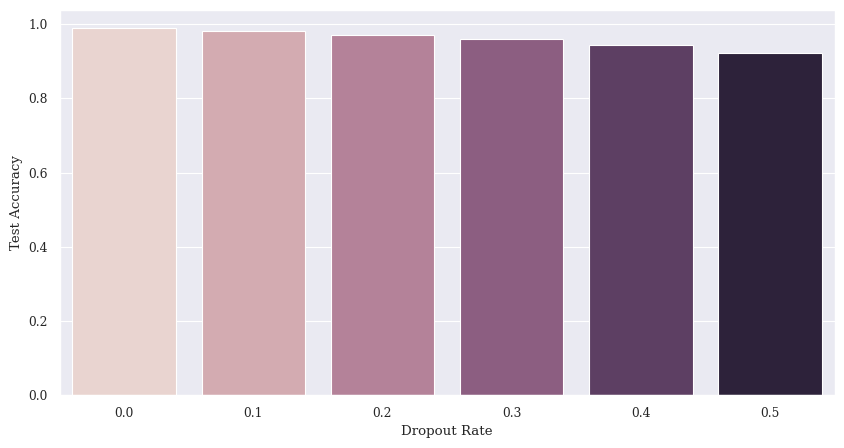

In [263]:
# read logs
logs_paths = os.listdir("different_dropout/logs")
summary_results = []
for path in logs_paths:
    dropout_rate = float(path.split("_")[-1])
    path = os.path.join("different_dropout/logs", path)
    df = pd.read_csv(path)
    last_epoch_acc = df["train_epoch_MulticlassAccuracy"].iloc[-1]
    last_epoch_loss = df["train_epoch_loss"].iloc[-1]
    summary_results.append(
        {
            "dropout_rate": dropout_rate,
            "last_epoch_acc": last_epoch_acc,
            "last_epoch_loss": last_epoch_loss,
        }
    )
summary_results = pd.DataFrame(summary_results)
fig = plt.figure(figsize=(10, 5))
sns.barplot(data=summary_results, 
            x="dropout_rate", 
            y="last_epoch_acc", 
            hue="dropout_rate",
            legend=False,
            )
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy")

Easy to see that higher dropuout rates lead to poor performance.

But how does the dropout rate affect the interpolated model?

In [322]:
dropout_state_dicts = {}
for path in os.listdir("different_dropout/checkpoints"):
    dropout_rate = float(path.split("_")[-1])
    path = os.path.join("different_dropout/checkpoints", path)
    ckpt = torch.load(path)
    print(f"Loading {path}")
    dropout_state_dicts[dropout_rate] = ckpt["model_state_dict"]
base_state_dict = dropout_state_dicts.pop(0.5)
tasks_pool = []
for dropout_rate, state_dict in dropout_state_dicts.items():
    for alpha in alphas:
        saving_dir = "different_dropout/interpolated_state_dicts"
        task = interpolate_weights.remote(
            f"dropout_rate_{dropout_rate}",
            base_state_dict,
            state_dict,
            alpha,
            saving_dir,
        )
        tasks_pool.append(task)
try:
    dropout_results = ray.get(tasks_pool)
except KeyboardInterrupt as e:
    # if keyboard interrupt, cancel all the tasks
    print(f"All tasks are cancelled due to {e}")
    ray.cancel(tasks_pool, force=True)
except Exception as e:
    # if any error occurs, print the error message
    # and gracefully terminate all the tasks
    # for debugging purpose
    print(e)
    ray.cancel(tasks_pool)
finally:
    dropout_results_dict = {}
    for result in dropout_results:
        name = result["name"]
        alpha = result["alpha"]
        state_dict = result["state_dict"]
        if name not in dropout_results_dict:
            dropout_results_dict[name] = {"alpha": [], "state_dict": []}
        dropout_results_dict[name]["alpha"].append(alpha)
        dropout_results_dict[name]["state_dict"].append(state_dict)

Loading different_dropout/checkpoints/dropout_rate_0.5
Loading different_dropout/checkpoints/dropout_rate_0.3
Loading different_dropout/checkpoints/dropout_rate_0
Loading different_dropout/checkpoints/dropout_rate_0.1
Loading different_dropout/checkpoints/dropout_rate_0.2
Loading different_dropout/checkpoints/dropout_rate_0.4


In [92]:
# rewrite the evaluation function a bit
def evaluate_interpolated_model(
    name: str,
    model_builder: Callable[[], nn.Module],
    model_state_dict: dict,
    device: Literal["cpu", "cuda"]="cuda",
):
    model = model_builder()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    metrics = MetricCollection(
        [
            Accuracy(task="multiclass", num_classes=10),
        ]
    )
    from logger import DummyPrintLogger, LoggerCollection
    loggers = LoggerCollection([DummyPrintLogger()])
    try:
        model.load_state_dict(model_state_dict)
    except Exception as e:
        print(f"Error when loading state dict: {e}")
        return None
    from pytorch_lightning import seed_everything
    seed_everything(42)
    _, mnist_testset = prepare_dataset("MNIST")
    mnist_test_loader = DataLoader(mnist_testset, batch_size=1024, num_workers=4)
    trainer = DefaultTrainer(
        model=model,
        optimizer = optimizer,
        criterion=criterion,
        metrics=metrics,
        loggers=loggers,
        device=device,
        need_saving=False,
    )
    results = trainer.evaluate(mnist_test_loader)  
    test_loss = results["test_epoch_loss"]
    test_acc = results["test_epoch_MulticlassAccuracy"]
    results = {"name": name, "test_loss": test_loss, "test_acc": test_acc}
    # trainer.save()
    # release GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [324]:
# evaluate interpolated models
model_builder = build_dropout_mlp_model
rmt_evaluate_interpolated_model = ray.remote(num_gpus=0.1)(
    evaluate_interpolated_model)
tasks_pool = []
for name, data in dropout_results_dict.items():
    alphas = data["alpha"]
    state_dicts = data["state_dict"]
    for alpha, state_dict in zip(alphas, state_dicts):
        task_name = f"{name}-alpha:{alpha:.2f}"
        task = rmt_evaluate_interpolated_model.remote(
            task_name, model_builder, state_dict, "cuda"
        )
        tasks_pool.append(task)

In [325]:
dropout_evaluated_results = ray.get(tasks_pool)

(evaluate_interpolated_model pid=3965638) Global seed set to 42


(evaluate_interpolated_model pid=3965638) Evaluation Starts


 10%|█         | 1/10 [00:01<00:09,  1.07s/it] 


(evaluate_interpolated_model pid=3965638) Evaluation Ends
(evaluate_interpolated_model pid=3965638) Test Results: {'test_epoch_MulticlassAccuracy': 0.9753000140190125, 'test_epoch_loss': 0.08518714606761932}


100%|██████████| 10/10 [00:01<00:00,  7.60it/s] 
(evaluate_interpolated_model pid=3965642) Global seed set to 42 [repeated 39x across cluster]
100%|██████████| 10/10 [00:01<00:00,  6.51it/s] 


(evaluate_interpolated_model pid=3965979) Evaluation Starts [repeated 2x across cluster]
(evaluate_interpolated_model pid=3965702) Evaluation Ends
(evaluate_interpolated_model pid=3965702) Test Results: {'test_epoch_MulticlassAccuracy': 0.9610000252723694, 'test_epoch_loss': 0.13972695767879487}


  0%|          | 0/10 [00:00<?, ?it/s]3965979) 
(evaluate_interpolated_model pid=3969876) Global seed set to 42 [repeated 2x across cluster]
 10%|█         | 1/10 [00:03<00:28,  3.12s/it] 


(evaluate_interpolated_model pid=3965979) Evaluation Ends
(evaluate_interpolated_model pid=3965979) Test Results: {'test_epoch_MulticlassAccuracy': 0.9771000146865845, 'test_epoch_loss': 0.07532574385404586}


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 6x across cluster]


(evaluate_interpolated_model pid=3965940) Evaluation Starts [repeated 6x across cluster]


(evaluate_interpolated_model pid=3970580) Global seed set to 42
 10%|█         | 1/10 [00:03<00:30,  3.40s/it] [repeated 5x across cluster]


(evaluate_interpolated_model pid=3965655) Evaluation Ends [repeated 4x across cluster]
(evaluate_interpolated_model pid=3965655) Test Results: {'test_epoch_MulticlassAccuracy': 0.819100022315979, 'test_epoch_loss': 0.8437583863735199} [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 14x across cluster]


(evaluate_interpolated_model pid=3966049) Evaluation Starts [repeated 18x across cluster]


(evaluate_interpolated_model pid=3972514) Global seed set to 42 [repeated 2x across cluster]
 10%|█         | 1/10 [00:02<00:22,  2.52s/it] [repeated 23x across cluster]


(evaluate_interpolated_model pid=3965747) Evaluation Ends [repeated 20x across cluster]
(evaluate_interpolated_model pid=3965747) Test Results: {'test_epoch_MulticlassAccuracy': 0.9761999845504761, 'test_epoch_loss': 0.08062539640814066} [repeated 20x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 16x across cluster]


(evaluate_interpolated_model pid=3965641) Evaluation Starts [repeated 13x across cluster]


(evaluate_interpolated_model pid=3977092) Global seed set to 42 [repeated 9x across cluster]
 10%|█         | 1/10 [00:02<00:20,  2.33s/it] [repeated 14x across cluster]


(evaluate_interpolated_model pid=3965641) Evaluation Ends [repeated 13x across cluster]
(evaluate_interpolated_model pid=3965641) Test Results: {'test_epoch_MulticlassAccuracy': 0.9420999884605408, 'test_epoch_loss': 0.5226371884346008} [repeated 13x across cluster]
(evaluate_interpolated_model pid=3969488) Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 2x across cluster]


(evaluate_interpolated_model pid=3969876) Evaluation Starts


(evaluate_interpolated_model pid=3978238) Global seed set to 42
 10%|█         | 1/10 [00:00<00:08,  1.04it/s] [repeated 3x across cluster]


(evaluate_interpolated_model pid=3972514) Evaluation Ends [repeated 5x across cluster]
(evaluate_interpolated_model pid=3972514) Test Results: {'test_epoch_MulticlassAccuracy': 0.972000002861023, 'test_epoch_loss': 0.09095948338508605} [repeated 5x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 5x across cluster]


(evaluate_interpolated_model pid=3976086) Evaluation Starts [repeated 8x across cluster]


 10%|█         | 1/10 [00:00<00:06,  1.44it/s] [repeated 12x across cluster]


(evaluate_interpolated_model pid=3977818) Evaluation Ends
(evaluate_interpolated_model pid=3977818) Test Results: {'test_epoch_MulticlassAccuracy': 0.9591000080108643, 'test_epoch_loss': 0.14298871532082558}


100%|██████████| 10/10 [00:01<00:00,  7.88it/s] 


In [326]:
dropout_evaluated_results
dropout_evaluated_results = pd.DataFrame(dropout_evaluated_results)
get_alpha = lambda x: float(x.split(":")[-1])
get_model_name = lambda x: x.split("-")[0]
dropout_evaluated_results['model for comparison'] = dropout_evaluated_results['name'].apply(get_model_name)
dropout_evaluated_results['alpha'] = dropout_evaluated_results['name'].apply(get_alpha)
dropout_evaluated_results.head()

,name,test_loss,test_acc,model for comparison,alpha
0,dropout_rate_0.3-alpha:0.00,0.085187,0.9753,dropout_rate_0.3,0.0
1,dropout_rate_0.3-alpha:0.10,0.092353,0.9760,dropout_rate_0.3,0.1
2,dropout_rate_0.3-alpha:0.20,0.187320,0.9709,dropout_rate_0.3,0.2
3,dropout_rate_0.3-alpha:0.30,0.522637,0.9421,dropout_rate_0.3,0.3
4,dropout_rate_0.3-alpha:0.40,1.038928,0.7855,dropout_rate_0.3,0.4


In [327]:
dropout_evaluated_results['dropout_rate'] = dropout_evaluated_results['model for comparison'].apply(lambda x: float(x.split("_")[-1]))

In [328]:
with open("pkl/dropout_interpolated_models_accuracy.pkl", "wb") as f:
    pickle.dump(dropout_evaluated_results, f)

In [85]:
# if rerunning, pleas load the saved pickle file
dropout_evaluated_results = pickle.load(open("pkl/dropout_interpolated_models_accuracy.pkl", "rb"))

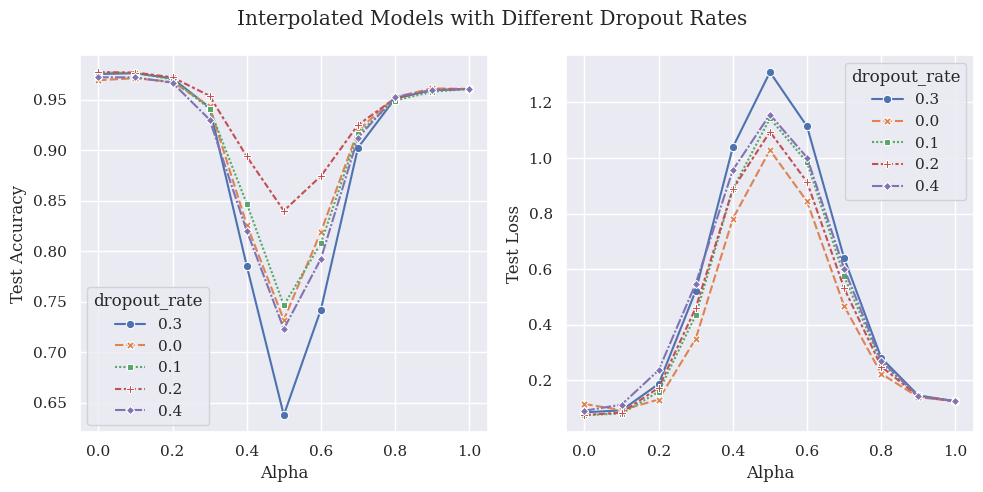

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=dropout_evaluated_results,
                ax=axs[0],
                x="alpha",
                y="test_acc",
                hue=dropout_evaluated_results['dropout_rate'].astype(str),
                legend=True,
                markers=True,
                style=dropout_evaluated_results['dropout_rate'].astype(str),
                )
sns.lineplot(data=dropout_evaluated_results,
                ax=axs[1],
                x="alpha",
                y="test_loss",
                hue=dropout_evaluated_results['dropout_rate'].astype(str),
                legend=True,
                markers=True,
                style=dropout_evaluated_results['dropout_rate'].astype(str),
                )
axs[0].set_xlabel("Alpha")
axs[0].set_ylabel("Test Accuracy")
axs[1].set_xlabel("Alpha")
axs[1].set_ylabel("Test Loss")
fig.suptitle("Interpolated Models with Different Dropout Rates")
fig.tight_layout()

It seems there is no clear correlation between higher dropout rates and lower interpolation gap

How about after permutation? 

In [87]:
dropout_permuted_results_dict = {}
tasks_pool = []
alphas = np.linspace(0, 1, num=11)
saving_dir = "different_dropout/permuted_interpolated_state_dicts"
dropout_state_dicts = {}
for path in os.listdir("different_dropout/checkpoints"):
    dropout_rate = float(path.split("_")[-1])
    path = os.path.join("different_dropout/checkpoints", path)
    ckpt = torch.load(path)
    print(f"Loading {path}")
    dropout_state_dicts[dropout_rate] = ckpt["model_state_dict"]
base_state_dict = dropout_state_dicts.pop(0)
rmt_permute_and_interpolate = ray.remote(num_gpus=0.1)(permute_and_interpolate)
for alpha in alphas:
    for dropout_rate, state_dict in dropout_state_dicts.items():
        task = rmt_permute_and_interpolate.remote(
            base_state_dict,
            state_dict,
            build_dropout_mlp_model,
            val_loader,
            alpha,
            f"dropout_rate_{dropout_rate}",
            saving_dir,
        )
        tasks_pool.append(task)

Loading different_dropout/checkpoints/dropout_rate_0.5
Loading different_dropout/checkpoints/dropout_rate_0.3
Loading different_dropout/checkpoints/dropout_rate_0
Loading different_dropout/checkpoints/dropout_rate_0.1
Loading different_dropout/checkpoints/dropout_rate_0.2
Loading different_dropout/checkpoints/dropout_rate_0.4


In [88]:
dropout_permuted_interpolated_results = ray.get(tasks_pool)

In [89]:
dropout_permuted_results_dict = {}
for result in dropout_permuted_interpolated_results:
    name = result["name"]
    alpha = result["alpha"]
    state_dict = result["state_dict"]
    if name not in dropout_permuted_results_dict:
        dropout_permuted_results_dict[name] = {"alpha": [], "state_dict": []}
    dropout_permuted_results_dict[name]["alpha"].append(alpha)
    dropout_permuted_results_dict[name]["state_dict"].append(state_dict)

In [159]:
dropout_permuted_results_dict

{'dropout_rate_0.5': {'alpha': [0.0,
   0.1,
   0.2,
   0.30000000000000004,
   0.4,
   0.5,
   0.6000000000000001,
   0.7000000000000001,
   0.8,
   0.9,
   1.0],
  'state_dict': [{'0.weight': tensor([[-0.0087, -0.0052,  0.0542,  ...,  0.0449, -0.0098,  0.0034],
            [ 0.0070,  0.0017,  0.0157,  ..., -0.0181, -0.0154,  0.0225],
            [ 0.0092, -0.0209, -0.0313,  ...,  0.0037,  0.0253,  0.0075],
            ...,
            [-0.0037, -0.0149,  0.0238,  ...,  0.0506,  0.0383,  0.0097],
            [-0.0139, -0.0100, -0.0028,  ..., -0.0178, -0.0263,  0.0260],
            [ 0.0018,  0.0270, -0.0009,  ..., -0.0212, -0.0174, -0.0131]]),
    '0.bias': tensor([ 0.0097, -0.0264, -0.0117, -0.0108, -0.0258, -0.0011, -0.0164, -0.0386,
             0.0044,  0.0178, -0.0411,  0.0216, -0.0339, -0.0188, -0.0201, -0.0456,
             0.0120, -0.0270, -0.0156, -0.0350, -0.0406,  0.0188, -0.0271, -0.0067,
             0.0158,  0.0186, -0.0268, -0.0035,  0.0002,  0.0225,  0.0051, -0.0165,
 

In [93]:
tasks_pool = []
rmt_evaluate_interpolated_model = ray.remote(num_gpus=0.1)(
    evaluate_interpolated_model
)
for name, data in dropout_permuted_results_dict.items():
    alphas = data["alpha"]
    state_dicts = data["state_dict"]
    for alpha, state_dict in zip(alphas, state_dicts):
        task_name = f"{name}-alpha:{alpha:.2f}"
        task = rmt_evaluate_interpolated_model.remote(
            task_name, build_dropout_mlp_model, state_dict, "cuda"
        )
        tasks_pool.append(task)
dropout_permuted_evaluated_results = ray.get(tasks_pool)

(evaluate_interpolated_model pid=138488) Global seed set to 42


(evaluate_interpolated_model pid=138533) Evaluation Starts


  0%|          | 0/10 [00:00<?, ?it/s]138533) 
(evaluate_interpolated_model pid=138436) Global seed set to 42 [repeated 39x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
 60%|██████    | 6/10 [00:01<00:00,  4.48it/s] 


(evaluate_interpolated_model pid=138809) Evaluation Ends
(evaluate_interpolated_model pid=138809) Test Results: {'test_epoch_MulticlassAccuracy': 0.9690999984741211, 'test_epoch_loss': 0.11518064886331558}


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 31x across cluster]


(evaluate_interpolated_model pid=138716) Evaluation Starts [repeated 32x across cluster]


 10%|█         | 1/10 [00:02<00:19,  2.14s/it] [repeated 50x across cluster]
(evaluate_interpolated_model pid=150003) Global seed set to 42
100%|██████████| 10/10 [00:03<00:00,  2.86it/s] [repeated 51x across cluster]


(evaluate_interpolated_model pid=138695) Evaluation Ends [repeated 38x across cluster]
(evaluate_interpolated_model pid=138695) Test Results: {'test_epoch_MulticlassAccuracy': 0.9404000043869019, 'test_epoch_loss': 0.19416062906384468} [repeated 38x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 8x across cluster]


(evaluate_interpolated_model pid=138436) Evaluation Starts [repeated 7x across cluster]
(evaluate_interpolated_model pid=138436) Evaluation Ends
(evaluate_interpolated_model pid=138436) Test Results: {'test_epoch_MulticlassAccuracy': 0.96670001745224, 'test_epoch_loss': 0.11181994043290615}
(evaluate_interpolated_model pid=150003) Evaluation Starts [repeated 2x across cluster]


 10%|█         | 1/10 [00:03<00:32,  3.57s/it] [repeated 3x across cluster]
(evaluate_interpolated_model pid=152533) Global seed set to 42 [repeated 14x across cluster]
  0%|          | 0/10 [00:00<?, ?it/s]150003) 


(evaluate_interpolated_model pid=150003) Evaluation Ends
(evaluate_interpolated_model pid=150003) Test Results: {'test_epoch_MulticlassAccuracy': 0.9692999720573425, 'test_epoch_loss': 0.10605811290442943}


(evaluate_interpolated_model pid=152095) Evaluation Ends
(evaluate_interpolated_model pid=152095) Test Results: {'test_epoch_MulticlassAccuracy': 0.9401000142097473, 'test_epoch_loss': 0.18031385242938996}


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]0m 


In [94]:
dropout_permuted_evaluated_results = pd.DataFrame(dropout_permuted_evaluated_results)
get_alpha = lambda x: float(x.split(":")[-1])
get_model_name = lambda x: x.split("-")[0]
dropout_permuted_evaluated_results['model for comparison'] = dropout_permuted_evaluated_results['name'].apply(get_model_name)
dropout_permuted_evaluated_results['alpha'] = dropout_permuted_evaluated_results['name'].apply(get_alpha)
dropout_permuted_evaluated_results['dropout_rate'] = dropout_permuted_evaluated_results['model for comparison'].apply(lambda x: float(x.split("_")[-1]))

In [95]:
dropout_permuted_evaluated_results.head()

,name,test_loss,test_acc,model for comparison,alpha,dropout_rate
0,dropout_rate_0.5-alpha:0.00,0.124919,0.9605,dropout_rate_0.5,0.0,0.5
1,dropout_rate_0.5-alpha:0.10,0.135385,0.9581,dropout_rate_0.5,0.1,0.5
2,dropout_rate_0.5-alpha:0.20,0.160870,0.9476,dropout_rate_0.5,0.2,0.5
3,dropout_rate_0.5-alpha:0.30,0.196851,0.9349,dropout_rate_0.5,0.3,0.5
4,dropout_rate_0.5-alpha:0.40,0.229238,0.9247,dropout_rate_0.5,0.4,0.5


In [96]:
dropout_evaluated_results.head()

,name,test_loss,test_acc,model for comparison,alpha,dropout_rate
0,dropout_rate_0.3-alpha:0.00,0.085187,0.9753,dropout_rate_0.3,0.0,0.3
1,dropout_rate_0.3-alpha:0.10,0.092353,0.9760,dropout_rate_0.3,0.1,0.3
2,dropout_rate_0.3-alpha:0.20,0.187320,0.9709,dropout_rate_0.3,0.2,0.3
3,dropout_rate_0.3-alpha:0.30,0.522637,0.9421,dropout_rate_0.3,0.3,0.3
4,dropout_rate_0.3-alpha:0.40,1.038928,0.7855,dropout_rate_0.3,0.4,0.3


In [106]:
# total_droupot_results contains test_loss, test_acc, dropout_rate, alpha on
# both interpolated and permuted interpolated models with 
# additional column as "with_permutation" to indicate whether the model is permuted
# or not
dropout_evaluated_results['with_permutation'] = False
dropout_permuted_evaluated_results['with_permutation'] = True
total_dropout_results = pd.concat([dropout_evaluated_results, dropout_permuted_evaluated_results])

In [139]:
total_dropout_results["dropout_rate"] = pd.Categorical(
    total_dropout_results["dropout_rate"], 
    categories=sorted(total_dropout_results["dropout_rate"].unique()),
    ordered=True,
)

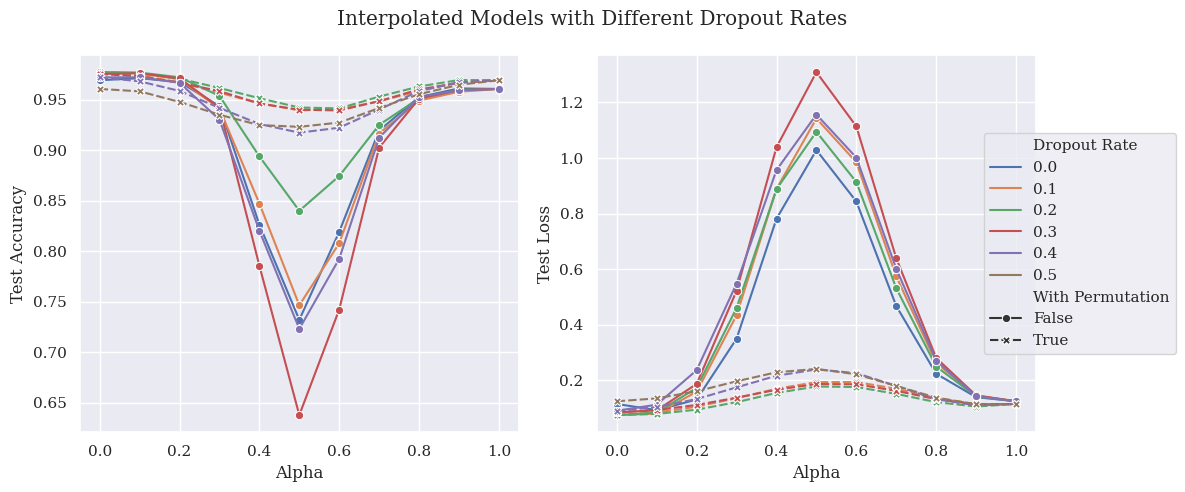

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=total_dropout_results,
                ax=axs[0],
                x="alpha",
                y="test_acc",
                hue=total_dropout_results['dropout_rate'],
                style=total_dropout_results['with_permutation'],
                legend=False,
                markers=True,
                )
sns.lineplot(data=total_dropout_results,
             ax=axs[1],
               x="alpha",
               y="test_loss",
               hue=total_dropout_results['dropout_rate'],
               style=total_dropout_results['with_permutation'],
               legend=True,
               markers=True,
               )
handles, labels = axs[1].get_legend_handles_labels()
for i in range(len(labels)):
    if labels[i] == "with_permutation":
        labels[i] = "With Permutation"
    if labels[i] == "dropout_rate":
        labels[i] = "Dropout Rate"

plt.legend(handles=handles, labels=labels, 
           loc="center", 
           bbox_to_anchor=(1.1, 0.5), ncol=1,
           )
axs[0].set_xlabel("Alpha")
axs[0].set_ylabel("Test Accuracy")
axs[1].set_xlabel("Alpha")
axs[1].set_ylabel("Test Loss")
fig.suptitle("Interpolated Models with Different Dropout Rates")
fig.tight_layout()

It seems that there is no clear correlation between the dropout rate in training and the interpolation gap.

---

Time to really factorize our code to make it more reusable.